# **Tutorial for cell-cell communication prediction for single-ST data with DeepTalk**

The notebook introduces to predicting cell-cell comunication using the DeepTalk method.

The notebook uses data from mouse brain cortex.

## **Installation**
Make sure ```DeepTalk_ST``` is installed via ```pip install DeepTalk_ST```.

The Python environment needs to install the packages listed in ```environment.yml```.

In [1]:
import sys
import os
import random
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import json
import seaborn as sns
import copy
from orderedset import OrderedSet
import DeepTalk_ST as dt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## **Create a work folder and Download the data**

The MERFISH_genes.csv, st_flie.txt, st_location.txt, single_cell_process.R, geneinfo.rda,pathways.rda, lrpairs_new.csv, df_pathways.csv can be downloaded from https://github.com/JiangBioLab/DeepTalk/tree/main/test.

In [2]:
Test_dir = './test/single-cell/'
isExists = os.path.exists(Test_dir)
if isExists:
    pass
else:
    os.makedirs(Test_dir)

In [3]:
'''
# Skip this cells if data are already downloaded
!wget http://jianglab.org.cn/deeptalk_download/visp_sn_tpm_small_0430.tar.gz -O ./Test1/single-cell/visp_sn_tpm_small_0430.tar.gz
!tar -xzvf visp_sn_tpm_small_0430.tar.gz -C Test_dir
'''

'\n# Skip this cells if data are already downloaded\n!wget http://jianglab.org.cn/deeptalk_download/visp_sn_tpm_small_0430.tar.gz -O ./Test1/single-cell/visp_sn_tpm_small_0430.tar.gz\n!tar -xzvf visp_sn_tpm_small_0430.tar.gz -C Test_dir\n'

## **Load spatial data**
Spatial data need to be organized as a voxel-by-gene matrix. Here, MERFISH data contains 2,399 spatial voxels, in each of which there are 268 genes measured.

In [4]:
random.seed(1000)
ad_st = sc.read_csv(Test_dir + "/st_flie.txt", delimiter='\t', first_column_names=True)
ad_st

AnnData object with n_obs × n_vars = 2399 × 268

In [5]:
ad_st_raw = copy.deepcopy(ad_st)
#ad_st_raw = ad_st
sc.pp.normalize_total(ad_st)
#ad_st_raw1 = copy.deepcopy(ad_st)
#sc.pp.normalize_per_cell(ad_st, counts_per_cell_after=1e4)
sc.pp.log1p(ad_st)

In [6]:
st_spatial = np.loadtxt(Test_dir + "/st_location.txt",dtype=str, delimiter=' ')
st_spatial = st_spatial.astype(np.float64)

In [7]:
ad_st.obs['x'] = st_spatial[:,0]
ad_st.obs['y'] = st_spatial[:,1]
ad_st.obsm["spatial"]=st_spatial
ad_st_raw.obsm["spatial"]=st_spatial

In [8]:
ad_st.obs.copy()

,x,y
0,1161.113371,6178.383054
1,1162.913371,6113.133054
2,1168.313371,6046.083054
3,1163.813371,6202.683054
4,1166.963371,6083.883054
...,...,...
2394,3144.263371,5201.433054
2395,3154.613371,5331.033054
2396,3165.413371,5190.183054
2397,3189.713371,5292.783054


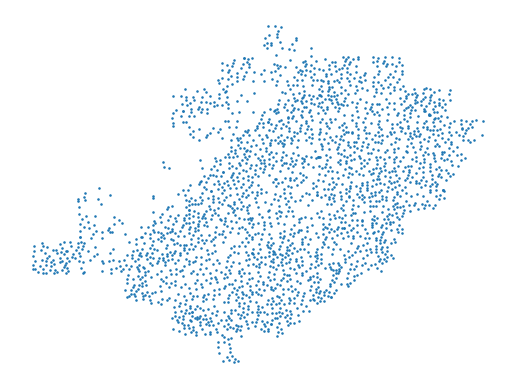

In [9]:
xs = ad_st.obs.x.values
ys = ad_st.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);
plt.gca().invert_yaxis()

## **Single cell data**
By single cell data, we generally mean either scRNAseq or snRNAseq.
They are 11,759 SMART-Seq2 snRNA-seq data from the VISp region.

In [10]:
path = os.path.join(Test_dir + "/visp_sn_tpm_small_0430.h5ad")
ad_sc = sc.read_h5ad(path)

In [11]:
ad_sc

AnnData object with n_obs × n_vars = 11759 × 40056
    obs: 'consensus_cluster', 'reference_cluster', 'reference_color', 'broad_class', 'subclass', 'merged_cluster_smFISH', 'merged_cluster_ISS', 'total_reads', 'cpm_scaling_factor', 'n_genes'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells'

Quality control is applied to single-cell data, as the data has already been preprocessed, this step can be skipped. Different quality control standards should be applied to different data

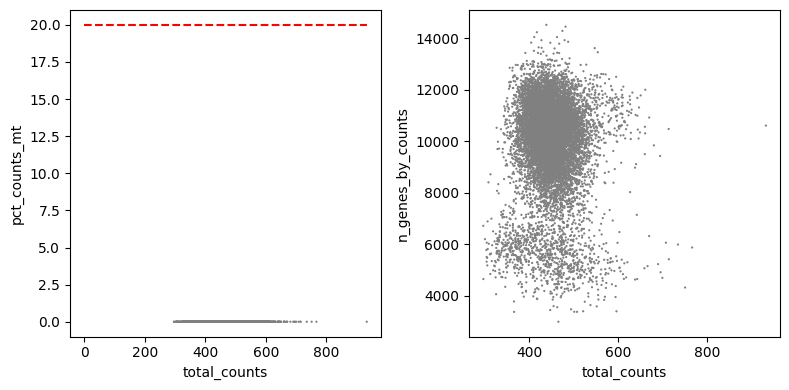

In [12]:
ad_sc.var["mt"] = ad_sc.var_names.str.startswith(r'^(mt-|MT-)')
sc.pp.calculate_qc_metrics(
    ad_sc, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)


fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
sc.pl.scatter(ad_sc, x='total_counts', y='pct_counts_mt',ax = axs[0], show=False)
sc.pl.scatter(ad_sc, x='total_counts', y='n_genes_by_counts',ax = axs[1], show = False)

ad_sc = ad_sc[ad_sc.obs['pct_counts_mt'] < 20]  
ad_sc = ad_sc[ad_sc.obs['n_genes_by_counts'] < 15000]  
ad_sc = ad_sc[ad_sc.obs['total_counts'] < 1000]

#draw horizontal red lines indicating thresholds.
axs[0].hlines(y = 20, xmin = 0, xmax = max(ad_sc.obs['total_counts']), color = 'red', ls = 'dashed') 
fig.tight_layout()
plt.show()

In [13]:
sc.pp.filter_cells(ad_sc, min_genes=200)
sc.pp.filter_genes(ad_sc, min_cells=3)
ad_sc_raw0 = copy.deepcopy(ad_sc)
sc.pp.normalize_total(ad_sc)
#sc.pp.normalize_per_cell(ad_sc, counts_per_cell_after=1e4)
ad_sc_raw1 = copy.deepcopy(ad_sc)
sc.pp.log1p(ad_sc)
ad_sc_raw = copy.deepcopy(ad_sc)
sc.pp.highly_variable_genes(ad_sc, min_mean=0.0125, max_mean=4, min_disp=0.25)
sc.pp.scale(ad_sc, max_value=10)
ad_sc_raw2 = copy.deepcopy(ad_sc)
sc.pp.pca(ad_sc)
sc.pp.neighbors(ad_sc)
sc.tl.umap(ad_sc)
ad_sc

AnnData object with n_obs × n_vars = 11759 × 40056
    obs: 'consensus_cluster', 'reference_cluster', 'reference_color', 'broad_class', 'subclass', 'merged_cluster_smFISH', 'merged_cluster_ISS', 'total_reads', 'cpm_scaling_factor', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [14]:
ad_sc_raw.obsm['X_umap']=ad_sc.obsm['X_umap']

## **Prepare to integration**

In [15]:
df_genes = pd.read_csv(Test_dir + '/MERFISH_genes.csv',header=None)
markers = np.reshape(df_genes.values[:,-1], (-1, ))
markers = list(markers)
len(markers)

254

In [16]:
dt.pp_adatas(ad_sc_raw, ad_st, genes=markers)

INFO:root:253 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:257 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


## **Integration sc/snRNA-seq and ST data**

In [17]:
ad_map = dt.map_cells_to_space(
    adata_sc=ad_sc_raw,
    adata_sp=ad_st,
    learning_rate=0.0001,
    num_epochs=3000,
    device='cuda:0',
)

Start training
Epoch 100, Loss: -0.529,Score0: 0.529,Time: 0.106
Epoch 200, Loss: -0.563,Score0: 0.563,Time: 0.100
Epoch 300, Loss: -0.589,Score0: 0.589,Time: 0.103
Epoch 400, Loss: -0.608,Score0: 0.608,Time: 0.102
Epoch 500, Loss: -0.622,Score0: 0.622,Time: 0.108
Epoch 600, Loss: -0.634,Score0: 0.634,Time: 0.102
Epoch 700, Loss: -0.642,Score0: 0.642,Time: 0.102
Epoch 800, Loss: -0.650,Score0: 0.650,Time: 0.103
Epoch 900, Loss: -0.656,Score0: 0.656,Time: 0.100
Epoch 1000, Loss: -0.662,Score0: 0.662,Time: 0.101
Epoch 1100, Loss: -0.667,Score0: 0.667,Time: 0.105
Epoch 1200, Loss: -0.672,Score0: 0.672,Time: 0.102
Epoch 1300, Loss: -0.677,Score0: 0.677,Time: 0.103
Epoch 1400, Loss: -0.681,Score0: 0.681,Time: 0.106
Epoch 1500, Loss: -0.685,Score0: 0.685,Time: 0.102
Epoch 1600, Loss: -0.689,Score0: 0.689,Time: 0.102
Epoch 1700, Loss: -0.692,Score0: 0.692,Time: 0.101
Epoch 1800, Loss: -0.696,Score0: 0.696,Time: 0.102
Epoch 1900, Loss: -0.699,Score0: 0.699,Time: 0.103
Epoch 2000, Loss: -0.702,

In [18]:
import torch
torch.cuda.empty_cache()

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


<Figure size 640x480 with 0 Axes>

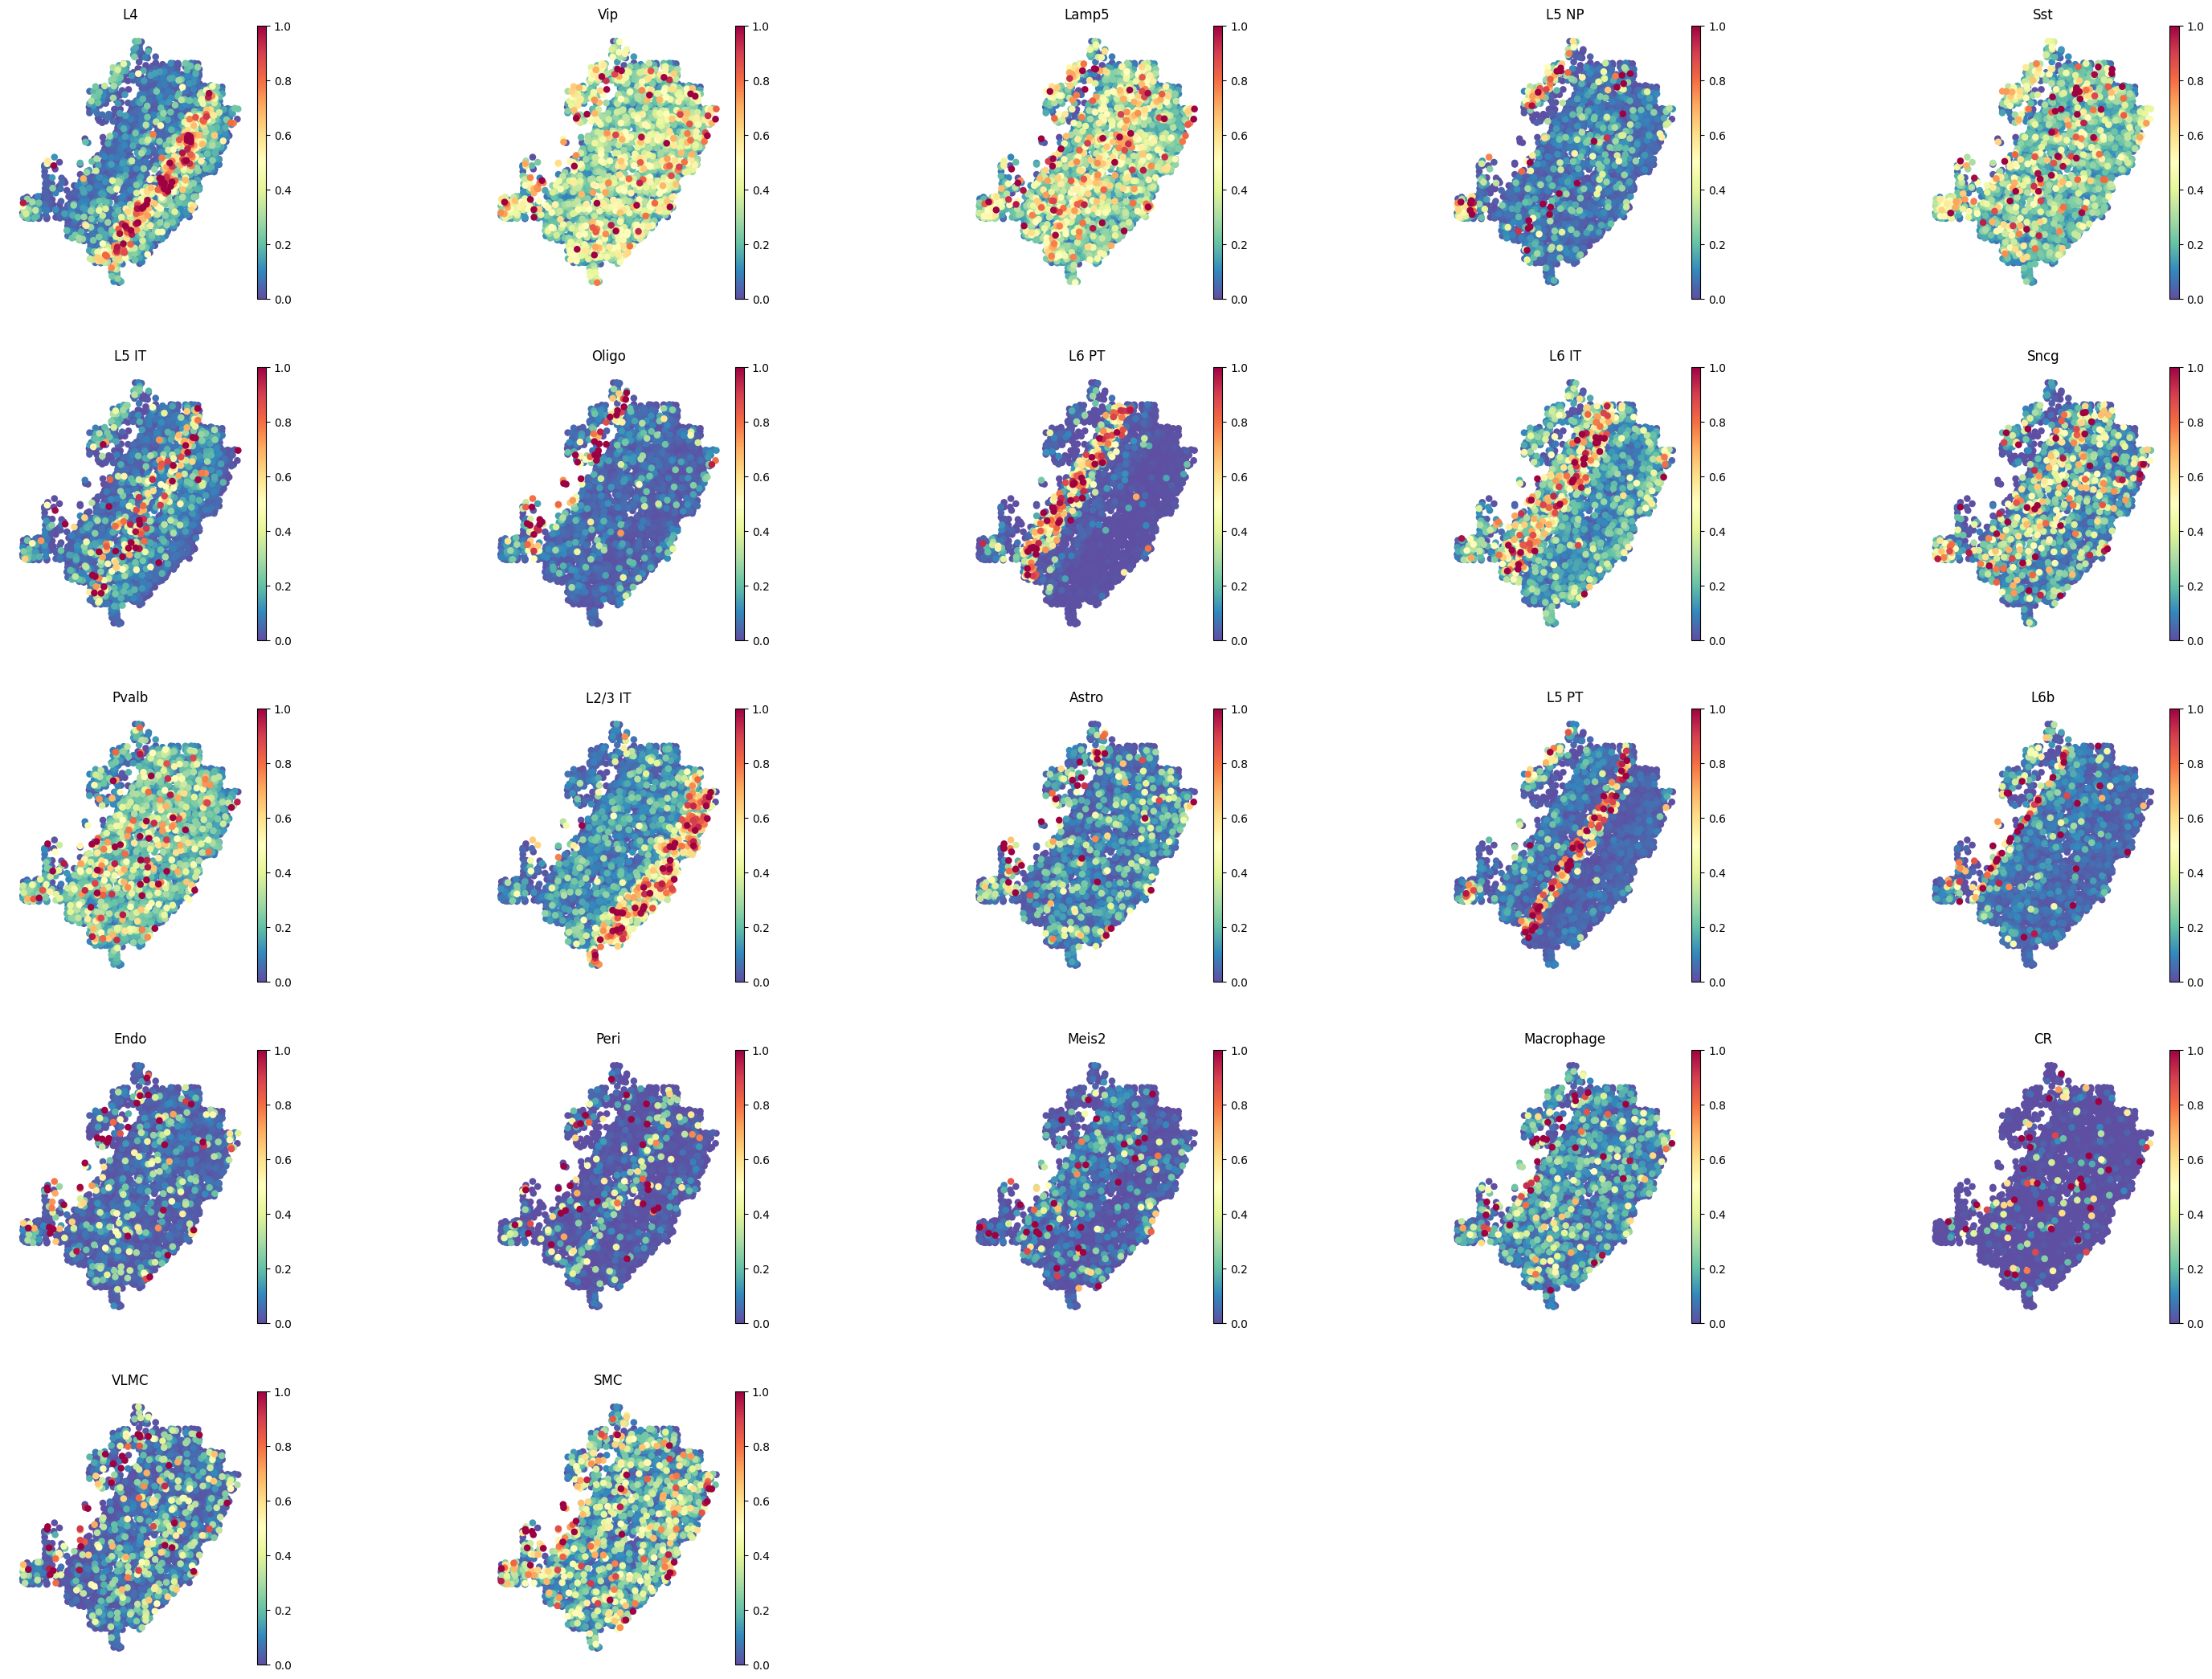

In [19]:
dt.project_cell_annotations(ad_map, ad_st, annotation="subclass")
annotation_list = list(pd.unique(ad_sc_raw.obs['subclass']))
dt.plot_cell_annotation_sc1(ad_st, annotation_list,spot_size=65, ncols=5,cmap='Spectral_r', scale_factor=0.1,perc=0.01)

## **Prepare to inference of cell-cell communication**

In [20]:
gene_all_mouse, gene_all_human = dt.gene_select(lrpairs = Test_dir + '/lrpairs_new.csv',TF = Test_dir + '/df_pathways.csv')

In [21]:
ad_ge = dt.project_genes(adata_map=ad_map, adata_sc=ad_sc_raw)
ad_ge

AnnData object with n_obs × n_vars = 2399 × 40056
    obs: 'x', 'y', 'uniform_density', 'rna_count_based_density'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'sparsity', 'is_training'
    uns: 'log1p', 'training_genes', 'overlap_genes'

In [22]:
sc.pp.filter_cells(ad_ge, min_genes=200)
sc.pp.filter_genes(ad_ge, min_cells=3)
sc.pp.filter_genes_dispersion(ad_ge, flavor='cell_ranger', log=False)
ad_ge = ad_ge[:, ad_ge.X.mean(axis=0) >= 0.1]
ad_ge

View of AnnData object with n_obs × n_vars = 2399 × 2051
    obs: 'x', 'y', 'uniform_density', 'rna_count_based_density', 'n_genes'
    var: 'length', 'maxMeanFpkm', 'in_MERFISH', 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'sparsity', 'is_training', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'training_genes', 'overlap_genes'

In [23]:
index1 = [word.capitalize() for word in ad_ge.var.index]
c_list = [f'C{i}' for i in range(1, ad_ge.X.shape[0]+1)]
st_data = pd.DataFrame(ad_ge.X.T,index=index1,columns=c_list)
st_data = st_data[st_data.index.isin(gene_all_mouse)]
#st_data.to_csv(Test_dir + '/ad_st_test.csv')
#df.to_csv(Test_dir + '/ad_st_test.csv',float_format='%.2f')
st_data

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C2390,C2391,C2392,C2393,C2394,C2395,C2396,C2397,C2398,C2399
Abhd6,0.142631,0.212360,0.160068,0.145656,0.262498,0.203882,0.236878,0.139545,0.205264,0.227960,...,0.383967,0.487171,0.298470,0.446355,0.349097,0.269817,0.548654,0.295749,0.673936,0.602151
Abr,0.070061,0.132820,0.091250,0.077609,0.174670,0.119295,0.139887,0.073344,0.117990,0.153953,...,0.218779,0.260347,0.149511,0.229871,0.174140,0.142323,0.258322,0.151556,0.413038,0.161295
Acaa1a,0.117449,0.167842,0.127871,0.098392,0.209848,0.175393,0.178980,0.125666,0.171929,0.370143,...,0.210564,0.497806,0.194109,0.320765,0.217124,0.160394,0.361521,0.179639,0.431825,0.356524
Acat1,0.214943,0.329608,0.180380,0.227757,0.463123,0.402539,0.289853,0.252313,0.308416,0.609850,...,0.392091,0.755492,0.360630,0.597916,0.386859,0.290806,0.583214,0.398806,0.879993,0.526327
Acot13,0.951231,1.248741,0.855937,0.853723,1.533524,1.561029,1.080712,1.006561,1.292423,2.757134,...,1.563040,2.393343,1.430070,2.608085,1.610389,1.170554,2.084162,1.548924,3.379546,2.697420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ywhae,1.211416,1.778149,1.151966,1.234732,2.322192,1.963170,1.501264,1.523583,1.803329,2.945517,...,2.529454,4.085746,2.149639,3.406856,2.569696,1.881820,3.494463,2.276314,3.974544,3.338981
Ywhag,0.212353,0.339915,0.222338,0.214213,0.498603,0.376677,0.262532,0.311770,0.337588,0.695913,...,0.407312,0.593674,0.354203,0.492657,0.425921,0.324199,0.526080,0.400103,0.644074,0.676226
Ywhah,1.386060,2.878993,1.220184,1.811978,3.623996,2.912498,2.169956,2.111476,2.570760,3.486536,...,3.994977,5.336713,3.012882,4.492794,3.757813,3.099985,4.166721,3.243228,4.016375,4.525685
Ywhaq,0.484975,0.725997,0.506451,0.498216,1.065612,0.774254,0.606715,0.564388,0.713330,1.382374,...,0.975706,1.569196,0.840275,1.330227,0.998201,0.741636,1.678585,0.877701,1.753874,1.350411


## **Generate training dataset and prediction dataset.**
Using the example of intercellular communication mediated by ```Sst-Sstr2``` and ```Apoe-Grm5```, train using ```Sst-Sstr2``` and predict intercellular communication mediated by ```Apoe-Grm5```.

In [24]:
pathways = Test_dir + "/pathways.csv"
species = "Mouse"
newmeta = ad_st.obs.copy()
newmeta.insert(0, 'cell', newmeta.index)
newmeta["cell"] = newmeta["cell"].astype(int) + 1
newmeta["cell"] = "C" + newmeta["cell"].astype(str)
st_coef = newmeta.iloc[:, 5:]
cellname = st_coef.columns
newmeta["celltype"] = ""
for i in range(st_coef.shape[0]):
    st_coef1 = st_coef.iloc[i, :]
    newmeta.iloc[i, newmeta.columns.get_loc('celltype')] = st_coef1.idxmax()
meta_data = newmeta[['cell', 'x', 'y', 'celltype']]
meta_data

,cell,x,y,celltype
0,C1,1161.113371,6178.383054,Vip
1,C2,1162.913371,6113.133054,L5 NP
2,C3,1168.313371,6046.083054,VLMC
3,C4,1163.813371,6202.683054,SMC
4,C5,1166.963371,6083.883054,Meis2
...,...,...,...,...
2394,C2395,3144.263371,5201.433054,L2/3 IT
2395,C2396,3154.613371,5331.033054,SMC
2396,C2397,3165.413371,5190.183054,Sncg
2397,C2398,3189.713371,5292.783054,Vip


In [25]:
mapping_colors = {
    "L6 CT": (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
    "L6 IT": (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
    "L5/6 NP": (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
    "L6b": "#0000c2ff",
    "L2/3 IT": "#a1ed7bff",
    "L5 IT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5 ET": (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
    "Oligo": (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
    "Vip": (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
    "Astro": "#ffdd55ff",
    "Micro-PVM": "#000000ff",
    "Pvalb": (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
    "Lamp5": (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
    "Sst": (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
    "Sst Chodl": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    "Sncg": (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    "Peri": (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
    "VLMC": (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
    "Endo": (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
    "Meis2": "#FFA500ff",
    "SMC": "#000000ff",
    "L6 PT": "#4682B4ff",
    "L5 PT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5 NP": "#6B8E23ff",
    "L4": "#d61f1dff",
    "Macrophage": "#2b2d2fff",
    "CR": "#000000ff",
}

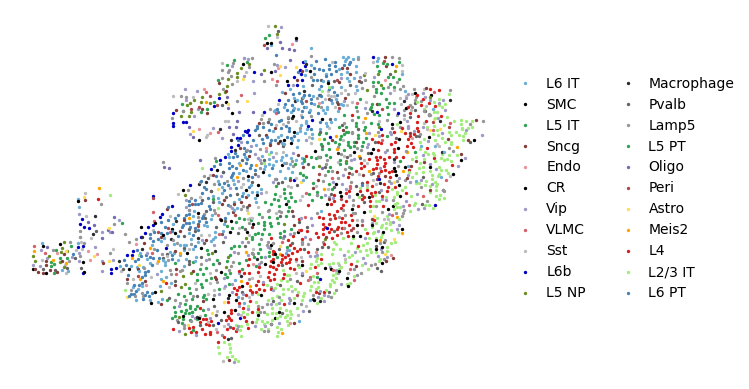

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
cluster = meta_data['celltype'].values
dt.plot_cell_type_ST(ad_st,mapping_colors,cluster)

## **Prediction of spatial CCC at the single-cell resolution.**
Train the data using subgraph-based GAT and generate a prediction model.

The trained model can be used to predict intercellular communication mediated by other L-R interactions.

In [27]:
lrpairs_train = {
    'ligand': ['Sst'],
    'receptor': ['Sstr2'],
    'species': ['Mouse']
}

lrpairs_train = pd.DataFrame(lrpairs_train)
lrpairs_train

,ligand,receptor,species
0,Sst,Sstr2,Mouse


In [28]:
dt.File_Train(st_data, pathways, lrpairs_train, meta_data, species, LR_train = 'Sst_Sstr2',
              outdir =  Test_dir)

**The training process may take some time. You can download trained models from github.**


In [29]:
dt.Train(data_name = 'Sst_Sstr2',data_path = Test_dir + '/data/',
    outdir = Test_dir + '/data/Sst_Sstr2/output',
    pretrained_embeddings = Test_dir + '/data/Sst_Sstr2/data_pca.emd',
    n_epochs = 50,ft_n_epochs=10)


 Loading graph...
DataSet Stats :
Number of Nodes 2399
Number of Edges 118483
Number of Node types 1
Number of relations 1
Graph with 2399 nodes and 118483 edges
2399 2
check torch.Size([2399, 128]) 2399
node2vec tensor torch.Size([2399, 128])
No. of nodes with pretrained embedding:  2399
No. edges in test data:  47795
***************PRETRAINING***************

 generate walks ...
no. of walks 19192
train ./test/single-cell//data//Sst_Sstr2/outdir/Sst_Sstr2_walks_train.txt
validate ./test/single-cell//data//Sst_Sstr2/outdir/Sst_Sstr2_walks_validate.txt
test ./test/single-cell//data//Sst_Sstr2/outdir/Sst_Sstr2_walks_test.txt

 Run model for pre-training ...

 Begin Training

Epoch: 0
MinLoss: 1000000.0, CurLoss: 7.9268
epoch time: (s) 31.95114231109619

Epoch: 10
MinLoss: 1000000.0, CurLoss: 7.8054
epoch time: (s) 30.530267000198364

Epoch: 20
MinLoss: 1000000.0, CurLoss: 7.7268
epoch time: (s) 31.17546510696411

Epoch: 30
MinLoss: 1000000.0, CurLoss: 7.291
epoch time: (s) 31.389280796

**Predicting cell-cell communication mediated by ```Apoe-Grm5```.**

In [30]:
lrpairs_pre = {
    'ligand': ['Apoe'],
    'receptor': ['Grm5'],
    'species': ['Mouse']
}

lrpairs_pre = pd.DataFrame(lrpairs_pre)
lrpairs_pre

,ligand,receptor,species
0,Apoe,Grm5,Mouse


In [31]:
dt.File_Pre(st_data, pathways, lrpairs_pre, meta_data, species, LR_Pre = 'Apoe_Grm5',
              outdir =  Test_dir)

In [32]:
dt.data_for_pre(st_data, data_dir = Test_dir +'/data/',
	LR_pre = 'Apoe_Grm5')

In [33]:
dt.run_predict(data_name='Apoe_Grm5',data_path = Test_dir +'/data/',
    outdir = Test_dir +'/data/Apoe_Grm5/output',
    pretrained_embeddings = Test_dir +'/data/Apoe_Grm5/data_pca_pre.emd',
    model_path = Test_dir + '/data/Sst_Sstr2/output/finetune/results',
    best_id = 8, is_trained = True, model_name = Test_dir + '/Sst_Sstr2.model')

DataSet Stats :
Number of Nodes 2324
Number of Edges 111881
Number of Node types 1
Number of relations 1
check torch.Size([2324, 128]) 2256
node2vec tensor torch.Size([2324, 128])
4 4 Linear(in_features=512, out_features=512, bias=True)
Begin Predicting
Done


## **Visualize of the spatial CCC**

**Spatial distribution of cell types**

**Spatial cell-cell communication at single-cell resolution**

Show Top 50 communication score for predticted cell-cell communication

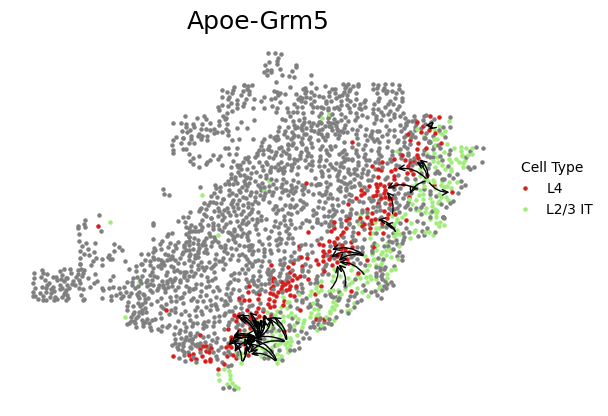

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
dt.plot_CCC_ST(ad_st, mapping_colors, cluster, st_data, ligand = 'Apoe',
    receptor = 'Grm5',CCC_label = Test_dir + '/data/Apoe_Grm5/predict_ccc.txt',
    sourcetype = 'L2/3 IT',targettype = 'L4',top_score = 50)

**Cell-cell communication between cell types**

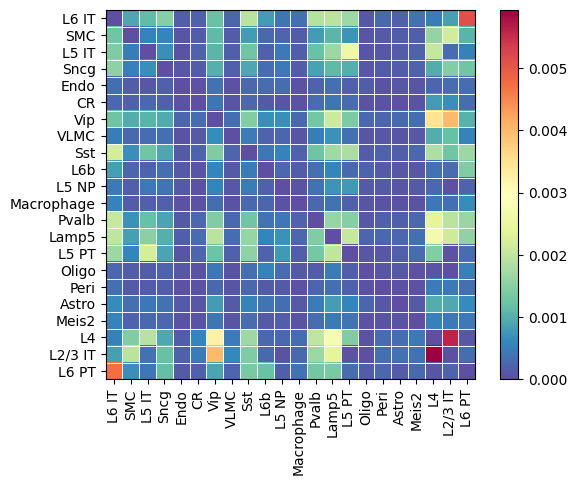

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
dt.plot_CCC_heatmap(cluster, st_data, ligand = 'Apoe', receptor = 'Grm5',
    CCC_label = Test_dir + '/data/Apoe_Grm5/predict_ccc.txt')